# Melanoma Classification

Kaggle Competition Page: www.kaggle.com/c/siim-isic-melanoma-classification/overview

## Setup

In [1]:
import os
import glob
import json
import random
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import matplotlib.image as mpimg
from keras.optimizers import Adam
from datetime import datetime, date
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from keras.applications.vgg16 import VGG16
from pandas_profiling import ProfileReport
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

In [8]:
SEED = 1
FOLDS = 10
EPOCHS = 200
BATCH_SIZE = 64
NUM_CLASSES = 2
VERBOSE_LEVEL = 2
SAVE_OUTPUT = False
IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

CWD = os.getcwd()
AUTOTUNE = tf.data.experimental.AUTOTUNE

GOOGLE_COLAB = False
if CWD == "/content":
    GOOGLE_COLAB = True

print ('Running in colab:', GOOGLE_COLAB)


Running in colab: False


In [3]:
def seed_all(seed):
    ''' A function to seed everything for getting reproducible results. '''
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = str(seed)
    os.environ['TF_KERAS'] = str(seed)
    tf.random.set_seed(seed)
    
seed_all(1)

In [4]:
MIXED_PRECISION = True
XLA_ACCELERATE = True
GPUS = 0

print("Tensorflow version " + tf.__version__)

print('Using default strategy for CPU and single GPU')
strategy = tf.distribute.get_strategy()

GPUS = len(tf.config.experimental.list_physical_devices('GPU'))
if GPUS == 0:
    DEVICE = 'CPU'
else:
    DEVICE = 'GPU'
    if MIXED_PRECISION:
        from tensorflow.keras.mixed_precision import experimental as mixed_precision
        policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
        mixed_precision.set_policy(policy)
        print('Mixed precision enabled')
    if XLA_ACCELERATE:
        tf.config.optimizer.set_jit(True)
        print('Accelerated Linear Algebra enabled')

REPLICAS = strategy.num_replicas_in_sync
STRATEGY = strategy

# Update BATCH_SIZE
BATCH_SIZE = BATCH_SIZE * REPLICAS

print("REPLICAS", REPLICAS)
print("DEVICE", DEVICE)

Tensorflow version 2.3.1
Using default strategy for CPU and single GPU
REPLICAS 1
DEVICE CPU


In [5]:
base_path = '/kaggle/input/siim-isic-melanoma-classification'
path_to_images = '/kaggle/input/siim-isic-melanoma-classification/jpeg' 
image_type = ".jpg"

# check on which system we are
if os.path.exists(CWD + '/data'):
    base_path = os.path.join(CWD, 'data')
    path_to_images = base_path
    image_type = ".png"
    print("change base_path to ", base_path)

elif GOOGLE_COLAB:
    CWD = "/content/melanoma-classification"
    base_path = os.path.join(CWD, 'data')
    path_to_images = base_path
    image_type = ".png"
    print("change base_path to ", base_path)

change base_path to  /workspaces/melanoma-classification/data


In [6]:
# get the data
train = pd.read_csv(os.path.join(base_path, 'train.csv'))
test = pd.read_csv(os.path.join(base_path, 'test.csv'))

## EDA

In [10]:
profile = ProfileReport(train,explorative=True)
## output the report to html
profile.to_file("output.html")
## print the report inline
profile

## Model preparation

In [39]:
# add the image_path
train['image_path'] = train['image_name'].apply(lambda x: path_to_images + "/train/" + x + image_type)
test['image_path'] = test['image_name'].apply(lambda x: path_to_images + "/test/" + x + image_type)

# getting dummy variables for gender
sex_dummies = pd.get_dummies(train['sex'], prefix='sex', dtype="int")
train = pd.concat([train, sex_dummies], axis=1)

sex_dummies = pd.get_dummies(test['sex'], prefix='sex', dtype="int")
test = pd.concat([test, sex_dummies], axis=1)

# getting dummy variables for anatom_site_general_challenge
anatom_dummies = pd.get_dummies(train['anatom_site_general_challenge'], prefix='anatom', dtype="int")
train = pd.concat([train, anatom_dummies], axis=1)

anatom_dummies = pd.get_dummies(test['anatom_site_general_challenge'], prefix='anatom', dtype="int")
test = pd.concat([test, anatom_dummies], axis=1)

# dropping not useful columns
train.drop(['sex','diagnosis','benign_malignant','anatom_site_general_challenge'], axis=1, inplace=True)
test.drop(['sex','anatom_site_general_challenge'], axis=1, inplace=True)

# replace missing age values wiht the mean age
train['age_approx'] = train['age_approx'].fillna(int(np.mean(train['age_approx'])))
test['age_approx'] = test['age_approx'].fillna(int(np.mean(test['age_approx'])))

# convert age to int
train['age_approx'] = train['age_approx'].astype('int')
test['age_approx'] = test['age_approx'].astype('int')

# Get a balanced dataset
# 1 means 50 / 50 => equal amount of positive and negative cases in Training
# 4 = 20 %; 8 = ~11%; 12 = ~8%
balance = 1
p_inds = train[train.target == 1].index.tolist()
np_inds = train[train.target == 0].index.tolist()

np_sample = random.sample(np_inds, balance * len(p_inds))
train = train.loc[p_inds + np_sample]
print("samples in train", train['target'].sum()/len(train))

print("rows in train", train.shape[0])
print("rows in test", test.shape[0])

samples in train 0.5
rows in train 1168
rows in test 10982


In [40]:
anatom_dummies = pd.get_dummies(train['target'], prefix='target', dtype="int")
train = pd.concat([train, anatom_dummies], axis=1)
train.head(1)

,image_name,patient_id,age_approx,target,image_path,sex_female,sex_male,anatom_head/neck,anatom_lower extremity,anatom_oral/genital,anatom_palms/soles,anatom_torso,anatom_upper extremity,target_0,target_1
91,ISIC_0149568,IP_0962375,55,1,/workspaces/melanoma-classification/data/train...,1,0,0,0,0,0,0,1,0,1


In [41]:
train.dtypes

image_name                object
patient_id                object
age_approx                 int64
target                     int64
image_path                object
sex_female                 int64
sex_male                   int64
anatom_head/neck           int64
anatom_lower extremity     int64
anatom_oral/genital        int64
anatom_palms/soles         int64
anatom_torso               int64
anatom_upper extremity     int64
target_0                   int64
target_1                   int64
dtype: object

In [42]:
# reduce the df and batch size when running on a cpu
if DEVICE == 'CPU':
    print("reduce the amount of data and the number of epchs and folds because of cpu runtime")
    # take 30% of the available data
    train = train.sample(int(train.shape[0] * 0.3))
    EPOCHS = 5

# validate the data - check all images in the df are valid
def check_image(file_path):
    img_file = Path(file_path)
    if img_file.is_file():
        return file_path
    return False

train['image_path'] = train.apply(lambda row : check_image(row['image_path']), axis = 1)
test['image_path'] = test.apply(lambda row : check_image(row['image_path']), axis = 1)

train = train[train['image_path'] != False]
test = test[test['image_path'] != False]

print("valid rows in train", train.shape[0])
print("valid rows in test", test.shape[0])

reduce the amount of data and the number of epchs and folds because of cpu runtime
valid rows in train 205
valid rows in test 10982


In [43]:
def create_splits(df, test_size, classToPredict):
    train_data, val_data = train_test_split(df,  test_size = test_size, random_state = SEED, stratify = df[classToPredict])
    return train_data, val_data

In [44]:
def get_training_gen(df):
    ## prepare images for training
    train_idg = ImageDataGenerator(
        rescale = 1 / 255.0,
        horizontal_flip = True, 
        vertical_flip = True, 
        height_shift_range = 0.1, 
        width_shift_range = 0.1, 
        rotation_range = 25, 
        shear_range = 0.1,
        zoom_range = 0.15
    )

    train_gen = train_idg.flow_from_dataframe(
        seed=SEED,
        dataframe=df,
        directory=None,
        x_col='image_path',
        y_col=['target_0','target_1'],
        class_mode='raw',
        shuffle=True,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        validate_filenames = False
    )

    return train_gen

In [45]:
def get_validation_gen(df):
    ## prepare images for validation
    val_idg = ImageDataGenerator(rescale=1. / 255.0)
    val_gen = val_idg.flow_from_dataframe(
        seed=SEED,
        dataframe=df,
        directory=None,
        x_col='image_path',
        y_col=['target_0','target_1'],
        class_mode='raw',
        shuffle=False,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        validate_filenames = False
    )

    return val_gen

Found 205 non-validated image filenames.


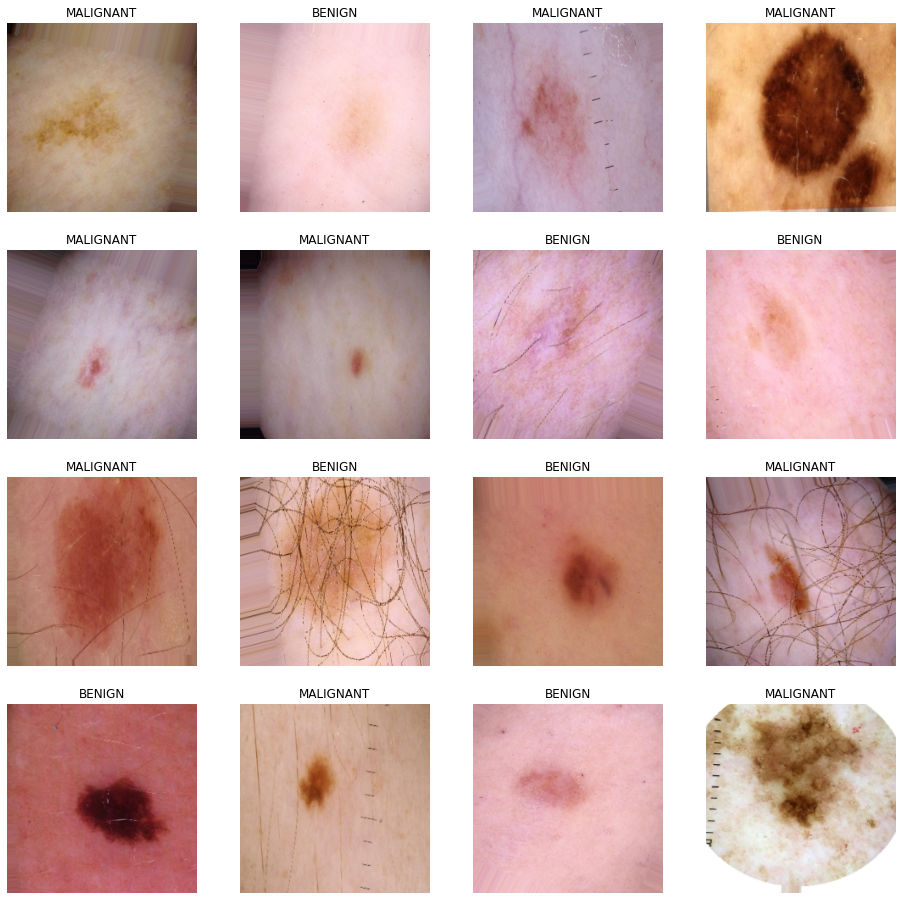

In [46]:
train_gen = get_training_gen(train)
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x, cmap = 'bone')
    if c_y[0] == 1: 
        c_ax.set_title('BENIGN')
    else:
        c_ax.set_title('MALIGNANT')
    c_ax.axis('off')

In [47]:
def save_history(history, timestamp):
    """Helper function to save a png image of the loss and accuracy
    Args:
        history ([tf history]): The history object of a tf model
    """
    f = plt.figure()
    f.set_figwidth(15)

    f.add_subplot(1, 2, 1)
    plt.plot(history['val_loss'], label='val loss')
    plt.plot(history['loss'], label='train loss')
    plt.legend()
    plt.title("Modell Loss")

    f.add_subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='val accuracy')
    plt.plot(history['accuracy'], label='train accuracy')
    plt.legend()
    plt.title("Modell Accuracy")

    if SAVE_OUTPUT:
        plt.savefig("./" + timestamp + "-history.png")
        with open("./" + timestamp + "-history.json", 'w') as f:
            json.dump(history, f)

In [48]:
def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    fig, c_ax = plt.subplots(1,1, figsize = (8, 8))
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Target', auc(fpr, tpr)))
    c_ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

In [ ]:
def load_pretrained_model():
    base_model = VGG16(
        input_shape=INPUT_SHAPE,
        include_top=False,
        weights='imagenet'
    )
    
    # freeze the first 15 layers of the model
    for layer in base_model.layers[0:15]:
        layer.trainable = False

    return base_model

In [50]:
def create_model():
    print("create model")

    # Create a new sequentail model and add the pretrained model
    model = Sequential()

    # Add the pretrained model
    model.add(load_pretrained_model())  

    # Add a flatten layer to prepare the ouput of the cnn layer for the next layers
    model.add(layers.Flatten())

    # Add a dense (aka. fully-connected) layer. This is for combining features that the res_model model has recognized in the image.
    # Add a dropout-layer which may prevent overfitting and improve generalization ability to unseen data e.g. the test-set.
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(32, activation='relu'))

    # Use the Sigmoid activation function for binary predictions, softmax for n-classes
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    return model

In [51]:
def create_experiment_model():
    print("create experiment model")
    model = Sequential([
        layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(INPUT_SHAPE)),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

In [52]:
# get the current timestamp
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

In [53]:
# set the weight path for saving the model
weight_path = "./" + timestamp + "-model.hdf5"

checkpoint = ModelCheckpoint(
    weight_path,
    save_weights_only=True,
    verbose=VERBOSE_LEVEL,
    save_best_only=True,
    monitor='val_loss',
    overwrite=True,
    mode='auto',
)

early = EarlyStopping(monitor='val_loss', mode='auto', patience=10)
callbacks_list = [early]

if SAVE_OUTPUT:
    callbacks_list.append(checkpoint)

In [54]:
# Define the model architecture
model = False
if DEVICE == 'CPU':
    model = create_experiment_model()
else:
    model = create_model()
    model.summary()


create experiment model


In [55]:
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()

rows in train_df 164
rows in val_df 41
Found 164 non-validated image filenames.
Found 41 non-validated image filenames.


In [56]:
LEARNING_RATE = 1e-4
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)

# when on a cpu, do not save the model data
if DEVICE == 'CPU':
    print("fit model on cpu")
    history = model.fit(
        train_gen, 
        epochs=EPOCHS, 
        verbose=VERBOSE_LEVEL,
        validation_data=(valX, valY)
    )
else:
    print("fit model on gpu")
    history = model.fit(
        train_gen, 
        epochs=EPOCHS, 
        verbose=VERBOSE_LEVEL,
        callbacks=callbacks_list, 
        validation_data=(valX, valY),
    )

fit model on cpu
Epoch 1/5
3/3 - 7s - loss: 0.6996 - accuracy: 0.5061 - auc: 0.5116 - val_loss: 0.6972 - val_accuracy: 0.5366 - val_auc: 0.4557
Epoch 2/5
3/3 - 13s - loss: 0.7288 - accuracy: 0.5244 - auc: 0.4507 - val_loss: 0.7049 - val_accuracy: 0.5366 - val_auc: 0.4289
Epoch 3/5
3/3 - 6s - loss: 0.6915 - accuracy: 0.5244 - auc: 0.5429 - val_loss: 0.6993 - val_accuracy: 0.4634 - val_auc: 0.5937
Epoch 4/5
3/3 - 14s - loss: 0.7170 - accuracy: 0.4817 - auc: 0.5429 - val_loss: 0.7177 - val_accuracy: 0.4634 - val_auc: 0.6062
Epoch 5/5
3/3 - 8s - loss: 0.7059 - accuracy: 0.4878 - auc: 0.5354 - val_loss: 0.6952 - val_accuracy: 0.4634 - val_auc: 0.5669


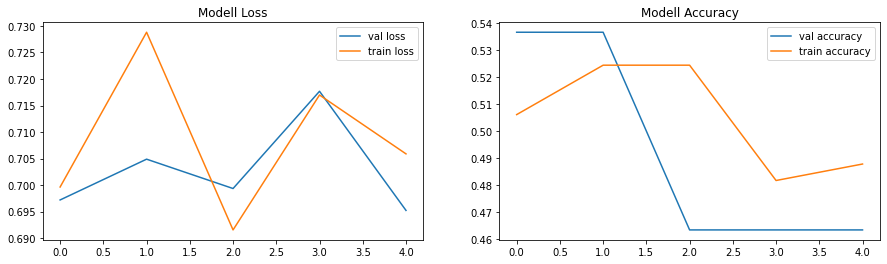

In [57]:
save_history(history.history, timestamp)
if SAVE_OUTPUT:
    model_json = model.to_json()
    with open("./" + timestamp + "-model.json", "w") as json_file:
        json_file.write(model_json)

In [58]:
y_t = []
y_p = []

for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

100%|██████████| 41/41 [00:09<00:00,  4.43it/s]


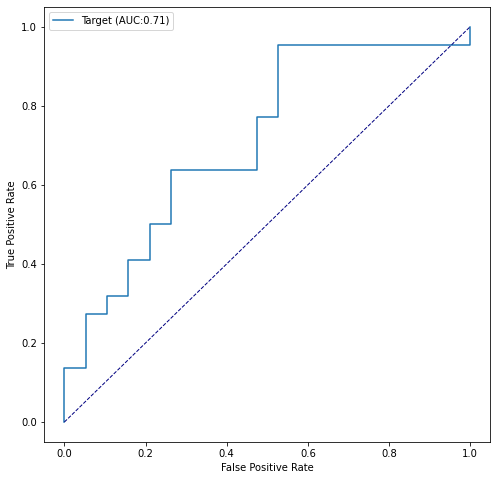

In [59]:
plot_auc(y_t, y_p)

In [60]:
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)

Chance of beeing malignant: 0.44 %


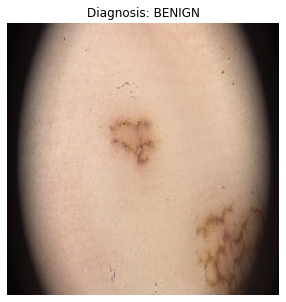

In [69]:
prediction = np.max(tf.nn.softmax(model.predict(img_array)[0])[1])
print("Chance of beeing malignant: {:.2f} %".format(prediction))
prediction = int(round(prediction))

finding = "Diagnosis: BENIGN"
if prediction == 1:
    finding = "Diagnosis: MALIGNANT"

x = plt.figure(figsize=(5,5))
x = plt.imshow(img)
x = plt.title(finding)
x = plt.axis("off")

In [62]:
test = test.head()

In [63]:
if SAVE_OUTPUT:
    data=[]

    for i in tqdm(range(test.shape[0])):
        image_path = test.iloc[i].image_path
        image_name = test.iloc[i].image_name
        img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255
        img_array = tf.expand_dims(img, 0)
        y_pred = model.predict(img_array)
        y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]
        data.append([image_name, y_pred])

    sub_df = pd.DataFrame(data, columns = ['image_name', 'target']) 
    sub_df.to_csv("./submission.csv", index=False)

    sub_df.head()

    #!kaggle competitions submit -c siim-isic-melanoma-classification -f submission.csv -m "Sub"

100%|██████████| 5/5 [00:01<00:00,  4.63it/s]
